Crossmatching tests
========

In the jupyter docker images, this requires running `pip install esutil astropy` in a terminal first.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
from esutil.htm import HTM

plt.rc('figure', dpi=120)

In [2]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql import Row

sc = SparkContext('local[*]')
sc.setLogLevel("WARN")

spark = SparkSession(sc)

In [239]:
%%time

#    n_measurements = np.random.poisson(200)
#    obj_ids = input_id*1000 + np.arange(n_measurements)

def make_measurements(input_id):
    
    #n_objects = np.random.poisson(200)
    n_objects = 10000
    sample_rate = 10
    obj_ra = 30*np.random.rand(n_objects)
    obj_dec = 30*np.random.rand(n_objects)
    
    randomize_counts = False
    if randomize_counts:
        sel_obj = np.random.choice(np.arange(len(obj_ra)), n_objects*sample_rate)
    else:
        sel_obj = np.arange(len(obj_ra)).repeat(sample_rate)
    
    source_ids = input_id*1000 + np.arange(len(sel_obj))
    source_ra = obj_ra[sel_obj] + 2/3600.0*np.random.randn(len(sel_obj)).clip(-2, 2)
    source_dec = obj_dec[sel_obj] + 2/3600.0*np.random.randn(len(sel_obj)).clip(-2, 2)

    # This is gross, but we have to return native python numeric types.
    return ((a.item(), b.item(), c.item()) for (a,b,c) in zip(source_ids, source_ra, source_dec))
    
raw_sources = sc.range(1).flatMap(make_measurements)

CPU times: user 10 ms, sys: 0 ns, total: 10 ms
Wall time: 10.7 ms


In [240]:
%%time
def add_htmid(object_tuple):
    htm_obj = HTM(depth=3)
    source_id, ra, dec = object_tuple
    htm_id = htm_obj.lookup_id(ra, dec)
    return htm_id.item()

grouped_rdd = raw_sources.keyBy(add_htmid).groupByKey()

CPU times: user 10 ms, sys: 10 ms, total: 20 ms
Wall time: 57.6 ms


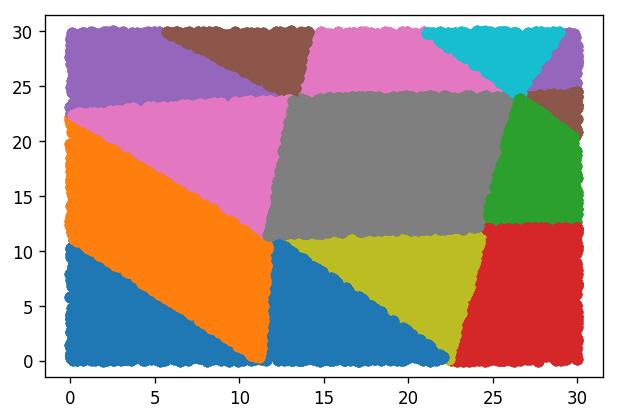

In [192]:
for id, values in grouped_rdd.collect():
    plt.plot([x[1] for x in values],
             [x[2] for x in values], 'o')

In [252]:
def match_sources(iterator):
    htm_id, values = iterator
    
    input_dict = {k: v for (k, v) in zip(range(len(values)), values)}
    source_ids = np.array([x[0] for x in values])
    ra = np.array([x[1] for x in values])
    dec = np.array([x[2] for x in values])

    tree = cKDTree(np.stack((ra, dec), axis=1))

    candidate_ids = set(range(len(ra)))
    output_groups = []
    while candidate_ids:
        this_id = candidate_ids.pop()
        dists, idx = tree.query( (ra[this_id], dec[this_id]), k=15, distance_upper_bound=4/3600.0)
        sel, = np.where((dists < 3/3600.0) & (idx != this_id))
        found_source_ids = source_ids[idx[sel]]
        this_group = [input_dict[this_id]]
        for n in idx[sel]:
            candidate_ids.discard(n)

            this_group.append((input_dict[n]))
        output_groups.append(this_group)

    return output_groups


In [253]:
def apply_obj_id(input):
    iterator, obj_id = input
    return [(obj_id,) + values for values in iterator]

# This flattens the per-htm partitioning
matched_groups = grouped_rdd.map(match_sources).flatMap(lambda x: x).zipWithUniqueId()

# This flattens the objects back into sources, but prepends the obj_id to each src record
tagged_source_records = matched_groups.flatMap(apply_obj_id)
source_table = spark.createDataFrame(tagged_source_records, schema=("obj_id", "source_id", "ra", "dec"))
source_table.registerTempTable("source_table")

In [254]:
summary_table = spark.sql("SELECT obj_id, mean(ra) as ra, mean(dec) as dec, count(*) as n_epochs "
                             "FROM source_table GROUP BY obj_id")
summary_table.registerTempTable("summary_table")

In [255]:
summary_table.limit(10).toPandas()

,obj_id,ra,dec,n_epochs
0,26,0.042372,1.915881,6
1,474,7.963760,3.311256,4
2,964,0.434791,10.465882,1
3,1806,1.960914,8.255173,8
4,1950,7.625334,3.575099,5
5,2040,0.037742,9.362090,1
6,2214,2.497681,4.396611,3
7,2250,1.523033,7.171334,2
8,3506,2.891630,4.430610,3
9,3764,2.787855,8.394902,8


In [256]:
few_epochs = spark.sql("SELECT ra, dec FROM summary_table WHERE n_epochs < 8 AND n_epochs > 2").toPandas()

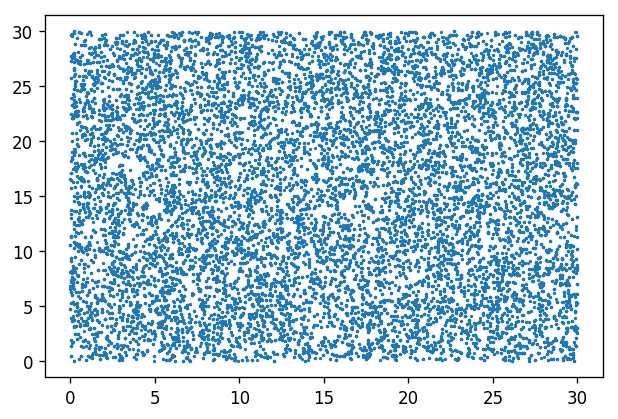

In [257]:
plt.plot(few_epochs['ra'], few_epochs['dec'], 'o', ms=1)

In [251]:
len(few_epochs)

22385